# Heart Disease Classification Model

### 1. Import Libraries

In [1]:
import zipfile
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

### 2. Data Extraction and Loading

In [2]:
def load_data(zip_file: str, extract_folder: str, csv_file: str):
    """Extract and load dataset."""
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    return pd.read_csv(f'{extract_folder}/{csv_file}')

df = load_data('Heart.zip', 'heart_data', 'heart.csv')

### 3. Initial Exploration

In [3]:
def initial_exploration(dataframe):
    """Display basic data insights."""
    print("Head of the DataFrame:")
    print(dataframe.head())
    print("\nData Info:")
    print(dataframe.info())
    print("\nDescriptive Statistics:")
    print(dataframe.describe())

initial_exploration(df)

Head of the DataFrame:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -

### 4. Data Cleaning

In [5]:
def clean_data(df):
    """Clean the data by handling missing values and outliers."""
    # Replace 0 values in columns with median
    df['RestingBP'] = df['RestingBP'].replace(0, df['RestingBP'].median())
    df['Cholesterol'] = df['Cholesterol'].replace(0, df['Cholesterol'].median())

    # Handle outliers for Cholesterol
    q1 = df['Cholesterol'].quantile(0.25)
    q3 = df['Cholesterol'].quantile(0.75)
    iqr = q3 - q1
    threshold = 1.5 * iqr
    df['Cholesterol'] = df['Cholesterol'].clip(lower=q1 - threshold, upper=q3 + threshold)

    return df

df = clean_data(df)

### 5. Feature Engineering and Preprocessing

In [6]:
def preprocess_data(df):
    """Preprocess the data by encoding categorical variables and scaling features."""
    # One-Hot Encoding for categorical variables
    df = pd.get_dummies(df, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

    # Split features and target
    X = df.drop('HeartDisease', axis=1)
    y = df['HeartDisease']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess_data(df)

### 6. Model Training and Evaluation

In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train multiple models and evaluate performance."""
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True)
    }

    results = {}
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        results[model_name] = {
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob),
            "roc_curve": (roc_curve(y_test, y_prob))
        }

    return results

model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

### 7. Model Selection & Hyperparameter Tuning

In [8]:
def grid_search_rf(X_train, y_train):
    """Hyperparameter tuning for Random Forest."""
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    print("\nBest Parameters for Random Forest:")
    print(grid_search.best_params_)
    
    return grid_search.best_estimator_

best_rf_model = grid_search_rf(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### 8. Model Saving and New Predictions

In [9]:
def save_and_predict_best_model(model, scaler):
    """Save the best model and predict using new data."""
    joblib.dump(model, 'best_heart_disease_model.pkl')

    # Simulate new patient data
    new_patient_data = {
        'Age': [52],
        'RestingBP': [138],
        'Cholesterol': [175],
        'FastingBS': [0],
        'MaxHR': [125],
        'Oldpeak': [1.2],
        'Sex_M': [1],
        'ChestPainType_ATA': [0],
        'ChestPainType_NAP': [1],
        'ChestPainType_TA': [0],
        'RestingECG_Normal': [1],
        'RestingECG_ST': [0],
        'ExerciseAngina_Y': [0],
        'ST_Slope_Flat': [1],
        'ST_Slope_Up': [0]
    }

    new_patient_df = pd.DataFrame(new_patient_data)
    new_patient_scaled = scaler.transform(new_patient_df)
    prediction = model.predict(new_patient_scaled)

    return "Heart Disease" if prediction[0] == 1 else "No Heart Disease"

# Save the model and predict
save_and_predict_best_model(best_rf_model, scaler)

'Heart Disease'

### 9. Visualizations for Insights

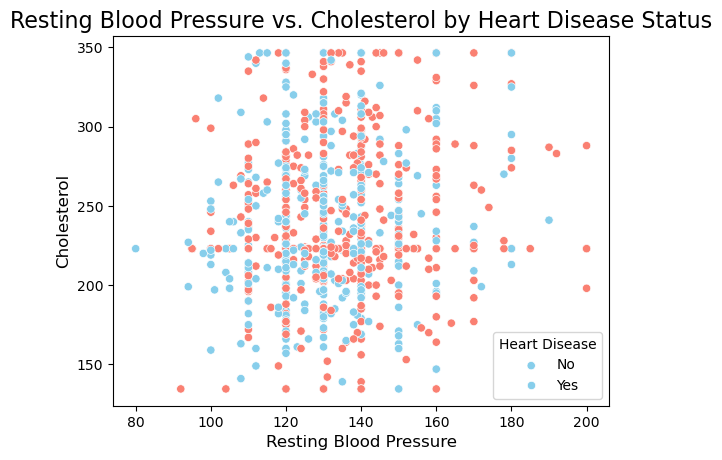

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


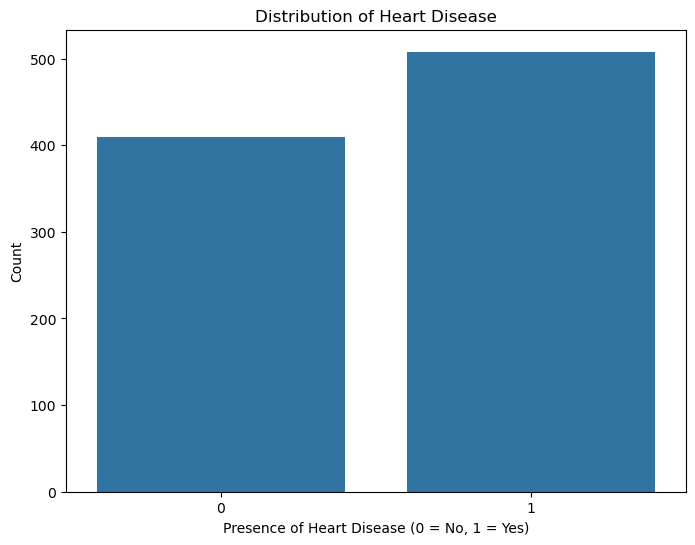

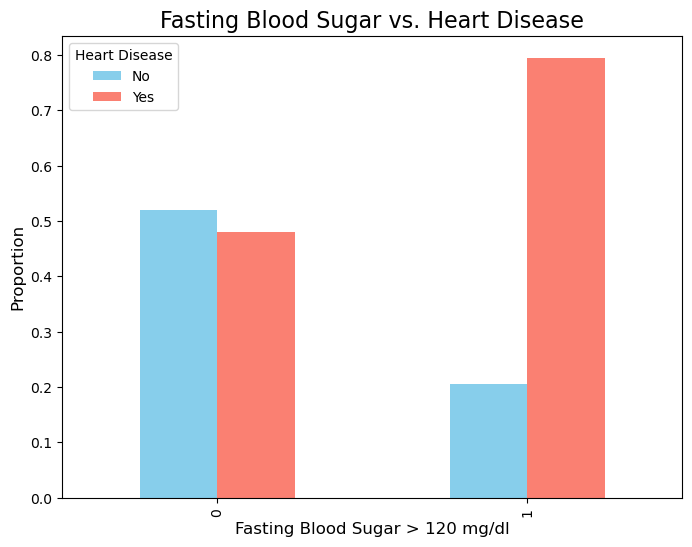

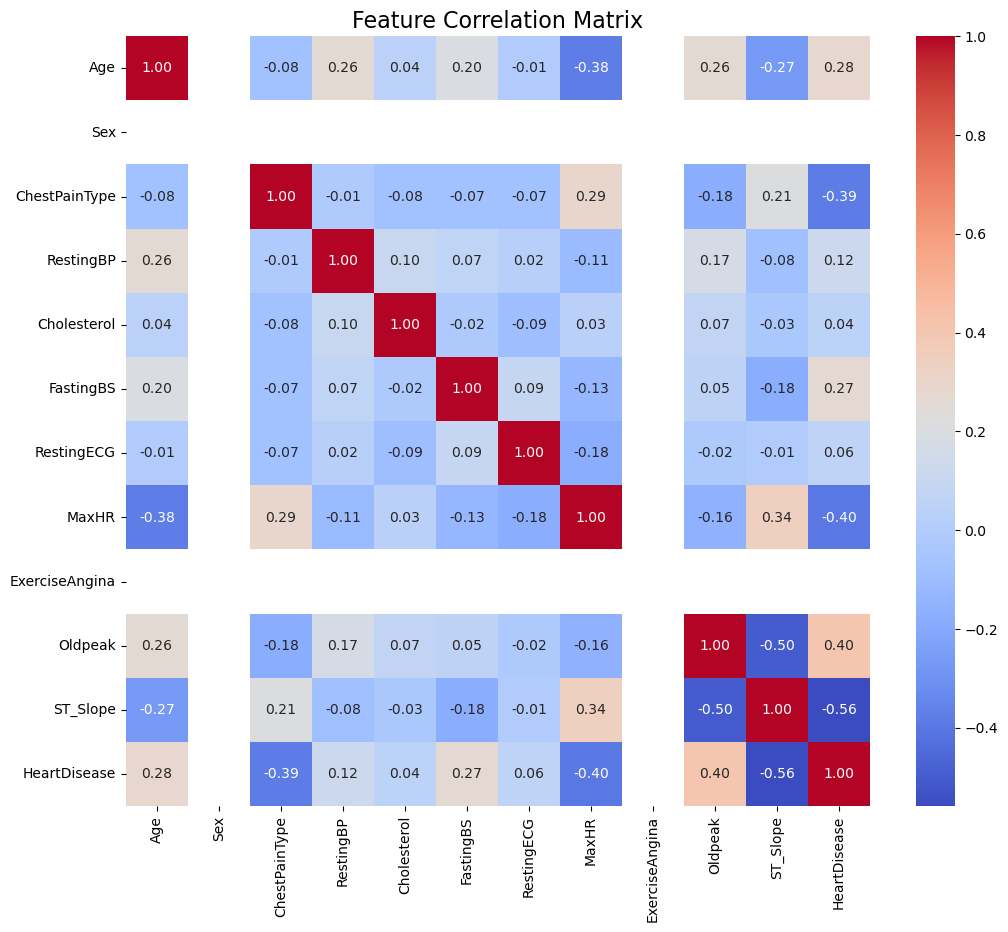

Accuracy: 0.86


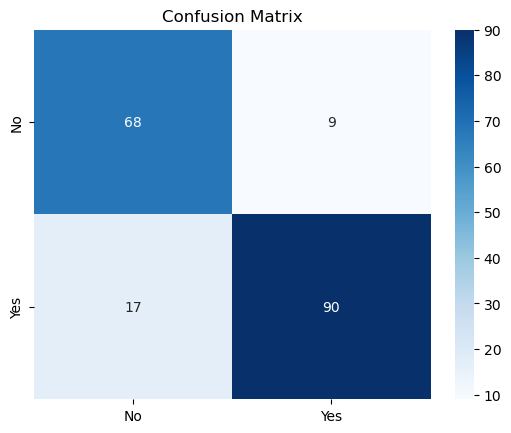

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84        77
           1       0.91      0.84      0.87       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

ROC-AUC: 0.92


In [20]:
def plot_insights(df):
    """Generate insights-based visualizations."""
    
    # Scatter plot: Resting BP vs Cholesterol
    sns.scatterplot(data=df, x='RestingBP', y='Cholesterol', hue='HeartDisease', palette=['skyblue', 'salmon'])
    plt.title('Resting Blood Pressure vs. Cholesterol by Heart Disease Status', fontsize=16)
    plt.xlabel('Resting Blood Pressure', fontsize=12)
    plt.ylabel('Cholesterol', fontsize=12)
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])
    plt.show()

    # Check column names in the dataframe
    print(df.columns)

    # Visualizing the target distribution (HeartDisease column)
    plt.figure(figsize=(8, 6))
    sns.countplot(x='HeartDisease', data=df)
    plt.xlabel('Presence of Heart Disease (0 = No, 1 = Yes)')
    plt.ylabel('Count')
    plt.title('Distribution of Heart Disease')
    plt.show()

    # Fasting Blood Sugar vs Heart Disease
    fasting_bs_disease = df.groupby('FastingBS')['HeartDisease'].value_counts(normalize=True).unstack()
    fasting_bs_disease.plot(kind='bar', figsize=(8, 6), color=['skyblue', 'salmon'])
    plt.title('Fasting Blood Sugar vs. Heart Disease', fontsize=16)
    plt.xlabel('Fasting Blood Sugar > 120 mg/dl', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.legend(title='Heart Disease', labels=['No', 'Yes'])
    plt.show()

    # Feature Correlation Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Feature Correlation Matrix', fontsize=16)
    plt.show()

def evaluate_model(model, X_test, y_test):
    """Evaluate the performance of the model."""
    
    # Predictions
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    # ROC-AUC Score
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC-AUC: {auc:.2f}")

# Encoding categorical columns based on the actual names
df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})  # Encoding 'Sex' column
df['ChestPainType'] = df['ChestPainType'].astype('category').cat.codes  # Encoding ChestPainType
df['RestingECG'] = df['RestingECG'].astype('category').cat.codes  # Encoding RestingECG
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})  # Encoding ExerciseAngina
df['ST_Slope'] = df['ST_Slope'].astype('category').cat.codes  # Encoding ST_Slope

# Train-test split
X = df.drop(columns=['HeartDisease'])  # Drop target column
y = df['HeartDisease']  # Target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Plot insights and evaluate the model
plot_insights(df)
evaluate_model(model, X_test, y_test)